<a href="https://colab.research.google.com/github/KruglovaKate/Test/blob/main/ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image, ImageDraw
from random import randint

In [2]:
class Figure():
    def __init__(self):
        R1 = randint(0,255)
        G1 = randint(0,255)
        B1 = randint(0,255)
        R2 = randint(0,255)
        G2 = randint(0,255)
        B2 = randint(0,255)
        im = Image.new('RGB', (640, 480), (R1,G1,B1))

        draw = ImageDraw.Draw(im)
        H = 480
        W = 640
        h = randint(150,250)
        w = randint(150,250)
        alpha = randint(0,89)*2*np.pi/360
        x1 = -w/2*np.cos(alpha)-h/2*np.sin(alpha)
        y1 = -w/2*np.sin(alpha)+h/2*np.cos(alpha)

        x2 = w/2*np.cos(alpha)-h/2*np.sin(alpha)
        y2 = w/2*np.sin(alpha)+h/2*np.cos(alpha)

        x3 = w/2*np.cos(alpha)+h/2*np.sin(alpha)
        y3 = w/2*np.sin(alpha)-h/2*np.cos(alpha)

        x4 = -w/2*np.cos(alpha)+h/2*np.sin(alpha)
        y4 = -w/2*np.sin(alpha)-h/2*np.cos(alpha)

        x1 = int(x1)
        x2 = int(x2)
        x3 = int(x3)
        x4 = int(x4)
        y1 = int(y1)
        y2 = int(y2)
        y3 = int(y3)
        y4 = int(y4)
        deltax = randint(max((x1,x2,x3,x4)),(W-max((x1,x2,x3,x4))))
        deltay = randint(max((y1,y2,y3,y4)),(H-max((y1,y2,y3,y4))))

        self.x1 = x1+deltax
        self.x2 = x2+deltax
        self.x3 = x3+deltax
        self.x4 = x4+deltax
        self.y1 = y1+deltay
        self.y2 = y2+deltay
        self.y3 = y3+deltay
        self.y4 = y4+deltay
        draw.polygon((self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,self.x4,self.y4), fill=(R2,G2,B2))
        self.X_op = min((self.x1,self.x2,self.x3,self.x4))
        self.Y_op = max((self.y1,self.y2,self.y3,self.y4))
        self.H_op = max((self.y1,self.y2,self.y3,self.y4)) - min((self.y1,self.y2,self.y3,self.y4))
        self.W_op = max((self.x1,self.x2,self.x3,self.x4)) - min((self.x1,self.x2,self.x3,self.x4))
      #  im.save('air_samples/sample1.png','PNG')
        self.image = np.array(im)
    def make_figure(self):
    
        return self.image,self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,self.x4,self.y4
        #return self.image,self.X_op,self.Y_op,self.X_op +self.W_op,self.Y_op+ self.H_op

In [3]:
from torch.utils.data import Dataset
import glob
from PIL import Image
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, length, transform = None):
      self.images = []
      self.coord = np.zeros((length,8))
      self.transform = transform
      for i in range(length):
        image = Figure()
        im, self.coord[i,0],self.coord[i,1],self.coord[i,2],self.coord[i,3],self.coord[i,4],self.coord[i,5],self.coord[i,6],self.coord[i,7]= image.make_figure()
        self.images.append(im)

    def __getitem__(self, i):
        if self.transform == None:
            im = self.images[i]
            coord = self.coord[i]
            return im, coord
        else:
            im = self.transform(self.images[i])
            coord = self.coord[i]
            return im, coord


    def __len__(self):
       return len(self.images)
    

In [5]:
train_dataset = CustomDataset(10000,transform =  transforms.Compose([transforms.ToTensor(),
              transforms.Resize([64,64]), transforms.Normalize(mean = 0, std = 1)
              ])) 
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle =True)

In [6]:
test_dataset = CustomDataset(1000,transform =  transforms.Compose([transforms.ToTensor(),
              transforms.Resize([64,64]), transforms.Normalize(mean = 0, std = 1)
              ])) 
test_loader = DataLoader(test_dataset, batch_size = 1)

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18

In [8]:
import torch
from tqdm import tqdm
def train(model, loss_function,optimizer , epochs ):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in  tqdm(train_loader):       
            optimizer.zero_grad() 
            outputs = model.forward(images) 
            loss = loss_function(outputs.float(), labels.float()) 
            loss.backward() 
            optimizer.step() 
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
    return loss_hist

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
resnet_detector = resnet18(pretrained=True)
resnet_detector.fc = nn.Linear(resnet_detector.fc.in_features, 8) 
optimizer = optim.RMSprop(resnet_detector.parameters(), lr=0.01, weight_decay=1e-8, momentum=0.9)
loss_hist = train(resnet_detector,  nn.MSELoss(), optimizer, epochs = 10)
#torch.save(resnet_detector.state_dict(), '/content/gdrive/MyDrive/resnet_detector_ep_10.pt')

Using device: cpu


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 625/625 [06:05<00:00,  1.71it/s]


Epoch=0 loss=4.941e+03


100%|██████████| 625/625 [06:05<00:00,  1.71it/s]


Epoch=1 loss=2.378e+03


100%|██████████| 625/625 [06:10<00:00,  1.69it/s]


Epoch=2 loss=1.622e+03


100%|██████████| 625/625 [06:21<00:00,  1.64it/s]


Epoch=3 loss=797.3


100%|██████████| 625/625 [06:30<00:00,  1.60it/s]


Epoch=4 loss=578.3


100%|██████████| 625/625 [07:36<00:00,  1.37it/s]


Epoch=5 loss=461.7


100%|██████████| 625/625 [10:14<00:00,  1.02it/s]


Epoch=6 loss=427.1


100%|██████████| 625/625 [13:33<00:00,  1.30s/it]


Epoch=7 loss=377.7


100%|██████████| 625/625 [16:34<00:00,  1.59s/it]


Epoch=8 loss=344.6


100%|██████████| 625/625 [18:57<00:00,  1.82s/it]

Epoch=9 loss=289.7


In [11]:
epoch = 10
loss = loss_hist[9]
torch.save({
            'epoch': epoch,
            'model_state_dict': resnet_detector.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/gdrive/MyDrive/_checkpoint_resnet_detector_ep_10.pt')

In [36]:
torch.save(resnet_detector, '/content/gdrive/MyDrive/full_resnet_detector_ep_10.pt')

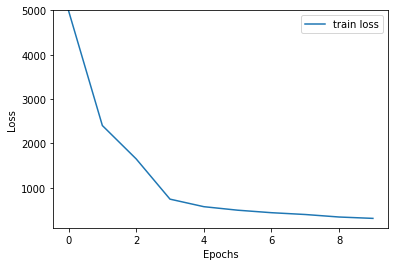

In [15]:
epochs = 10
plt.plot(range(epochs), loss_hist, label = 'train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([100,5*10**3])
plt.legend()
plt.show()

In [12]:
def test(model, loss_function):
  correct = 0
  total = 0
  loss_test = []
  L2_test = []
  
  ep_loss = 0
  with torch.no_grad():
      for data in tqdm(test_loader):
          loss_1 = 0
          loss_2 = 0
          loss_3 = 0
          loss_4 = 0
          loss_custom = 0
          images, labels = data
          outputs = model(images)

          loss_1 = np.sqrt((outputs[:,0]-labels[:,0])**2+(outputs[:,1]-labels[:,1])**2)
          loss_2 = np.sqrt((outputs[:,2]-labels[:,2])**2+(outputs[:,3]-labels[:,3])**2)
          loss_3 = np.sqrt((outputs[:,4]-labels[:,4])**2+(outputs[:,5]-labels[:,5])**2)
          loss_4 = np.sqrt((outputs[:,6]-labels[:,6])**2+(outputs[:,7]-labels[:,7])**2)
          loss_custom = (loss_1+loss_2+loss_3+loss_4)/4
          ep_loss += loss_custom
          L2_test.append(loss_custom)
          
  loss_test.append(ep_loss /len(test_loader))
  print(f"loss={loss_test[0]}")
  
  return loss_test, L2_test

In [15]:
loss_test, L2_test = test(resnet_detector, nn.MSELoss())

100%|██████████| 1000/1000 [00:37<00:00, 27.00it/s]


loss=tensor([32.4143], dtype=torch.float64)


In [17]:
max(L2_test)

tensor([177.8485], dtype=torch.float64)

In [18]:
min(L2_test)

tensor([6.2435], dtype=torch.float64)

**Checkpoint в середине обучения:**
********
Среднее L2 = 32
Максимум L2 = 178
Минимум L2  = 6

In [19]:
resnet_detector_2 = resnet18(pretrained=True)
resnet_detector_2.fc = nn.Linear(resnet_detector_2.fc.in_features, 8) 
optimizer = optim.RMSprop(resnet_detector_2.parameters(), lr=0.01, weight_decay=1e-8, momentum=0.9)

checkpoint = torch.load('/content/gdrive/MyDrive/_checkpoint_resnet_detector_ep_10.pt')
resnet_detector_2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
loss_hist = train(resnet_detector_2,  nn.MSELoss(), optimizer, epochs = 10)
torch.save(resnet_detector_2.state_dict(), '/content/gdrive/MyDrive/resnet_detector_ep_20.pt')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 625/625 [20:43<00:00,  1.99s/it]


Epoch=0 loss=304.1


100%|██████████| 625/625 [20:42<00:00,  1.99s/it]


Epoch=1 loss=268.6


100%|██████████| 625/625 [20:17<00:00,  1.95s/it]


Epoch=2 loss=236.2


100%|██████████| 625/625 [22:38<00:00,  2.17s/it]


Epoch=3 loss=255.0


100%|██████████| 625/625 [24:56<00:00,  2.39s/it]


Epoch=4 loss=208.3


100%|██████████| 625/625 [24:44<00:00,  2.37s/it]


Epoch=5 loss=195.4


100%|██████████| 625/625 [22:42<00:00,  2.18s/it]


Epoch=6 loss=194.5


100%|██████████| 625/625 [21:36<00:00,  2.07s/it]


Epoch=7 loss=192.1


100%|██████████| 625/625 [21:46<00:00,  2.09s/it]


Epoch=8 loss=167.3


100%|██████████| 625/625 [24:08<00:00,  2.32s/it]


Epoch=9 loss=154.7


In [20]:
loss_test2, L2_test2 = test(resnet_detector_2, nn.MSELoss())

100%|██████████| 1000/1000 [00:43<00:00, 23.18it/s]

loss=tensor([28.0996], dtype=torch.float64)


In [23]:
max(L2_test2)

tensor([188.3122], dtype=torch.float64)

In [24]:
min(L2_test2)

tensor([4.2459], dtype=torch.float64)

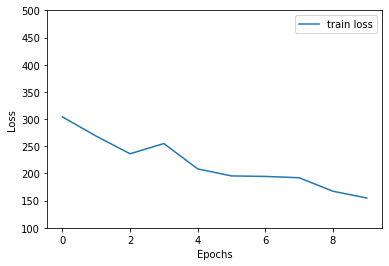

In [25]:
epochs = 10
plt.plot(range(epochs), loss_hist, label = 'train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([100,500])
plt.legend()
plt.show()

**Cрeckpoint в конце обучения:**
*******
Среднее L2 = 28
Максимум L2 = 188
Минимум L2 = 4